In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm, lognorm
from scipy.interpolate import interp1d
from numpy.random import lognormal
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd
import pymc3 as pm
from hyperopt import tpe, fmin, Trials, hp, space_eval
import seaborn as sns
import ternary
from ternary.helpers import simplex_iterator
from ternary.helpers import project_sequence
plt.style.use('seaborn-ticks')
# sns.set(style='ticks')
%matplotlib inline

### Bayesian linear regressoin

In [2]:
data = pd.read_csv('yields.csv', names=['sample', 'glucan', 'xylan', 'lignin', 'extractive', 'glu_y', 'xyl_y'], skiprows=1)
data.head()

,sample,glucan,xylan,lignin,extractive,glu_y,xyl_y
0,CS MP,34.53,22.89,14.13,9.38,30.498207,22.552940
1,SWG gen,36.54,24.02,19.87,6.86,27.951380,24.395195
2,SWG stored,37.91,24.16,20.94,5.20,36.616050,25.325567
3,CS stored,33.10,24.73,15.26,7.55,38.702958,28.441722
4,Grass ID,15.62,7.20,12.03,35.45,19.016070,7.009673


In [3]:
glu_data = data[['glucan', 'xylan', 'lignin', 'glu_y']]
xyl_data = data[['glucan', 'xylan', 'lignin', 'xyl_y']]
glu_data.columns = ['glucan', 'xylan', 'lignin', 'y']
xyl_data.columns = ['glucan', 'xylan', 'lignin', 'y']

In [4]:
def glm_mcmc_inference(df, iterations=12000):
    """
    Calculates the Markov Chain Monte Carlo trace of
    a Generalised Linear Model Bayesian linear regression 
    model on supplied data.

    df: DataFrame containing the data
    iterations: Number of iterations to carry out MCMC for
    """
    # Use PyMC3 to construct a model context
    basic_model = pm.Model()
    with basic_model:
        # Create the glm using the Patsy model syntax
        # We use a Normal distribution for the likelihood
        pm.glm.GLM.from_formula("y ~ glucan + xylan + lignin", df, family=pm.glm.families.Normal())

        # Use Maximum A Posteriori (MAP) optimisation as initial value for MCMC
        start = pm.find_MAP()

        # Use the No-U-Turn Sampler
        step = pm.NUTS()

        # Calculate the trace
        trace = pm.sample(
            iterations, step, start, 
            random_seed=42, progressbar=True
        )

    return trace[2000:]

In [5]:
# glucan_trace = glm_mcmc_inference(glu_data)
# xylan_trace = glm_mcmc_inference(xyl_data)

In [6]:
# import shelve
# with shelve.open('traces') as traces:
#     traces['glucan_trace'] = glucan_trace
#     traces['xylan_trace'] = xylan_trace

In [7]:
import shelve
with shelve.open('traces') as d:
    glucan_trace = d['glucan_trace']
    xylan_trace = d['xylan_trace']

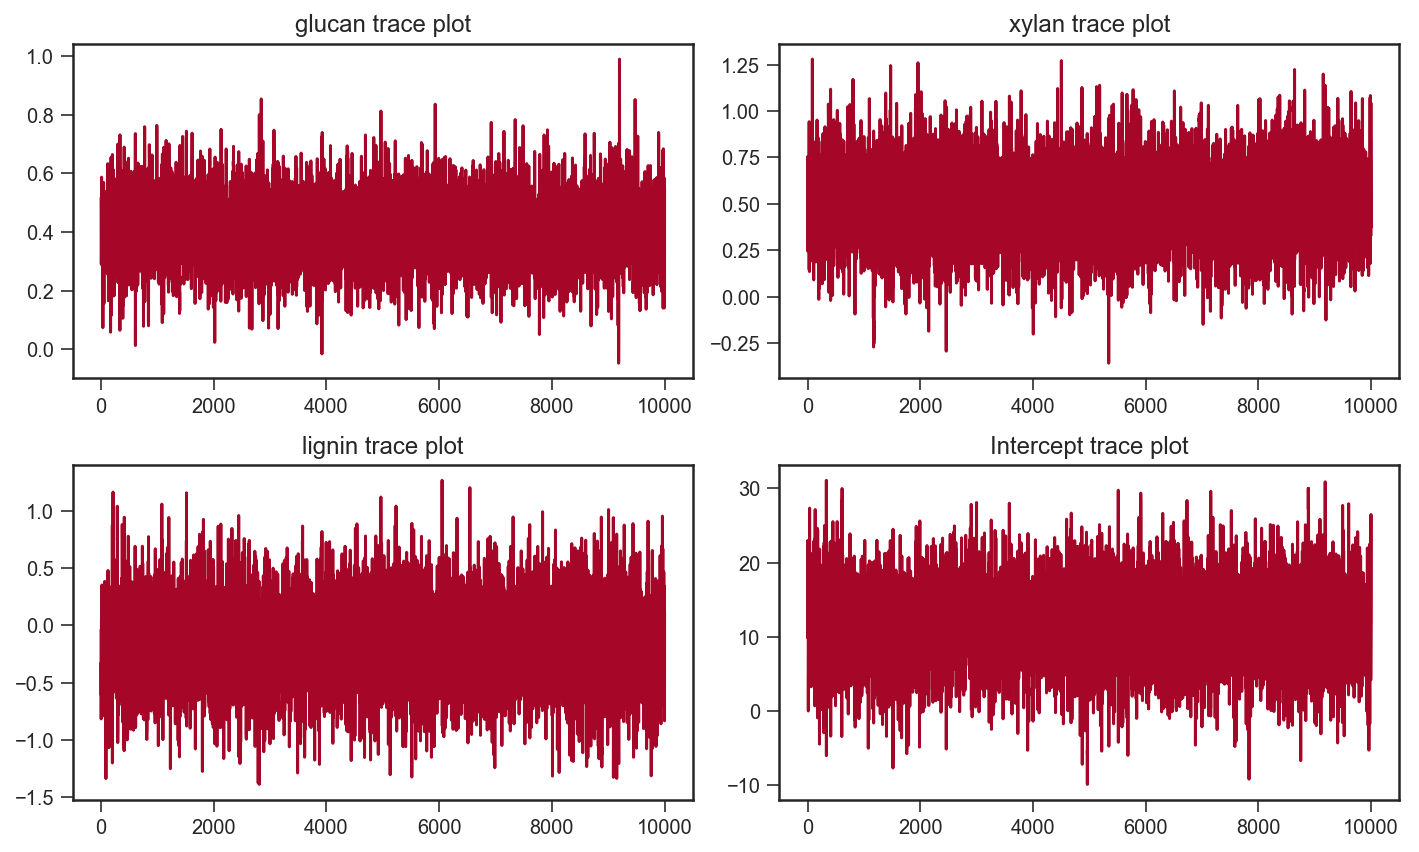

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
var = ['glucan', 'xylan', 'lignin', 'Intercept']
for col, axis in zip(var, ax.ravel()):
    axis.plot(glucan_trace[col], c='#A60628')
    axis.set_title(col + ' trace plot')
fig.tight_layout()

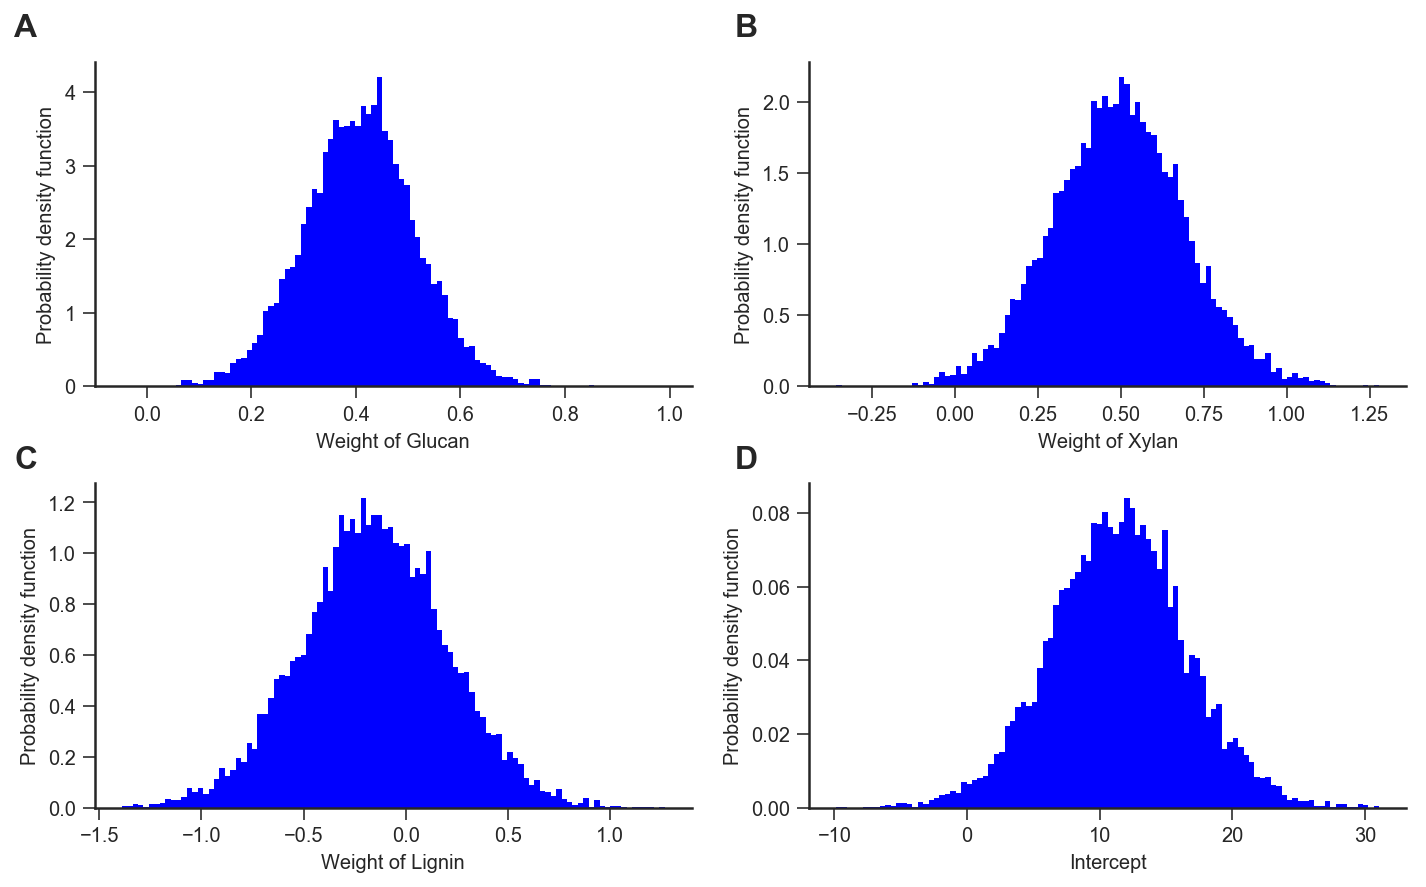

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
for col, axis in zip(var, ax.ravel()):
    axis.hist(glucan_trace[col], bins=100, normed=True, color='b')
    if col != 'Intercept':
        axis.set_xlabel('Weight of {}'.format(col.capitalize()))
    else:
        axis.set_xlabel('Intercept')
    axis.set_ylabel('Probability density function')
#     axis.text(0.1, 0.75, 'Mean: {:.2f}\nStd: {:.2f}'.format(glucan_trace[col].mean(), glucan_trace[col].std()), 
#               transform=axis.transAxes,
#               fontsize=12
#              )
fig.tight_layout()
sns.despine()
fig.text(0.01, 0.99, 'A', fontsize=16, fontweight='bold')
fig.text(0.51, 0.99, 'B', fontsize=16, fontweight='bold')
fig.text(0.01, 0.49, 'C', fontsize=16, fontweight='bold')
fig.text(0.51, 0.49, 'D', fontsize=16, fontweight='bold')
fig.savefig('posterior.png', dpi=300, bbox_inches='tight')

### Corn stover
* Glucan: avg 34.24 std 2.10
* Xylan: 20.52 std 1.81
* Lignin: 15.20 std 1.46
* Extractives: 12.19 std 2.09

### SWG
* Glucan: avg 33.69 std 2.54
* Xylan: 21.59 std 2.01
* Lignin: 19.47 std 1.09
* Extractives: 8.54 std 3.83

### Grass
* Glucan: avg 18.55 std 5.03
* Xylan: 9.46 std 7.29
* Lignin: 13.11 std 2.13
* Extractives: 32.10 std 10.04

In [10]:
thres = 32 * 0.9

In [11]:
class biomass():
    def __init__(self, price, xylan_trace=xylan_trace, glucan_trace=glucan_trace):
        self.glucan = None
        self.xylan = None
        self.lignin =None
        self.ext = None
        self.price = price
        self.xylan_trace = xylan_trace
        self.glucan_trace = glucan_trace
        
    def lin_reg(self, trace):
        '''
        This function generates linear function based on linear regression resuls.
        '''
        c1, c2, c3, intercept = trace['glucan'], trace['xylan'], trace['lignin'], trace['Intercept']
        return lambda x1, x2, x3: c1 * x1 + c2 * x2 + c3 * x3 + intercept
        
    def calYields(self):
        if (self.glucan is None) or (self.xylan is None) or (self.lignin is None) or (self.ext is None):
            raise RuntimeError('Please define feedstock component first !')
        else:
            tot_xyl = self.lin_reg(self.xylan_trace)     # The function to predict total xylan yields
            xylYields_mean = tot_xyl(self.glucan, self.xylan, self.lignin)

            tot_glu = self.lin_reg(self.glucan_trace)    # The function to predict total glucan yields
            gluYields_mean = tot_glu(self.glucan, self.xylan, self.lignin)
            
#             self.xylYileds_ = np.random.normal(xylYields_mean, self.xylan_trace['sd'])
#             self.gluYields_ = np.random.normal(gluYields_mean, self.glucan_trace['sd'])
            self.xylYileds_ = norm.rvs(xylYields_mean, self.xylan_trace['sd'], random_state=111)
            self.gluYields_ = norm.rvs(gluYields_mean, self.glucan_trace['sd'], random_state=123)
            return self.xylYileds_, self.gluYields_
    
    def meetTarget(self, target=thres):
        '''
        Returns the probability of meeting yield target
        '''
        tot_xyl, tot_glu = self.calYields()
        glu_ecdf = ECDF(tot_glu)
        xyl_ecdf = ECDF(tot_xyl)
        inv_cdfg = interp1d(glu_ecdf.y, glu_ecdf.x, bounds_error=False, assume_sorted=True)
        inv_cdfx = interp1d(xyl_ecdf.y, xyl_ecdf.x, bounds_error=False, assume_sorted=True)
        return 1 - glu_ecdf(target)

In [12]:
def logstat(mean, std):
    '''
    This function converts the mean and standard deviation of a lognormal distribution to the mean and standard
    deviations of the underlying normal distribution.
    '''
    logmean = np.log(mean**2/np.sqrt(std**2+mean**2))
    logstd = np.sqrt(np.log(std**2/mean**2+1))
    return (logstd, 0, np.exp(logmean))

In [13]:
def blend(csRatio=0.6, swgRatio=0.35, grassRatio=0.05):
    '''
    This function returns the blended biomass feedstock given the blending ratios of cs, swg and grass.
    '''
    if round(csRatio + swgRatio + grassRatio, 10) != round(1.0, 10):
        raise RuntimeError('Blending ratios must add up to 1! It is now {} !'.format(csRatio + swgRatio + grassRatio))
    if False:
        pass
    else:
        blendsPrice = csRatio * cs.price + swgRatio * + swg.price + grassRatio * grass.price
        blends = biomass(blendsPrice)
        blends.glucan = csRatio * cs.glucan + swgRatio * swg.glucan + grassRatio * grass.glucan
        blends.xylan = csRatio * cs.xylan + swgRatio * + swg.xylan + grassRatio * grass.xylan
        blends.lignin = csRatio * cs.lignin + swgRatio * + swg.lignin + grassRatio * grass.lignin
        blends.ext = csRatio * cs.ext + swgRatio * + swg.ext + grassRatio * grass.ext
        return blends

#### Random number generation:

In [14]:
size = 10000        # Size of monte carlo simulation
csPrice = 90
swgPrice = 80
grassPrice = 60

##### CS:

In [15]:
cs_glucan = norm.rvs(34.24, 2.10, size, random_state=7)
cs_xylan = norm.rvs(20.52, 1.81, size, random_state=13)
cs_lignin = norm.rvs(15.20, 1.46, size, random_state=19)
cs_ext = norm.rvs(12.19, 2.09, size, random_state=17)

In [16]:
cs = biomass(csPrice)
cs.glucan = cs_glucan
cs.xylan = cs_xylan
cs.lignin = cs_lignin
cs.ext = cs_ext

In [17]:
cs_tot_xyl, cs_tot_glu = cs.calYields()

##### SWG:

In [18]:
swg_glucan = norm.rvs(33.69, 2.54, size, random_state=21)
swg_xylan = norm.rvs(21.59, 2.01, size, random_state=23)
swg_lignin = norm.rvs(19.47, 1.09, size, random_state=29)
swg_ext = lognorm.rvs(*logstat(8.54, 3.83), size, random_state=27)

In [19]:
swg = biomass(swgPrice)
swg.glucan = swg_glucan
swg.xylan = swg_xylan
swg.lignin = swg_lignin
swg.ext = swg_ext

In [20]:
swg_tot_xyl, swg_tot_glu = swg.calYields()

##### Grass:

In [21]:
grass_glucan = lognorm.rvs(*logstat(18.55, 5.03), size, random_state=33)
grass_xylan = lognorm.rvs(*logstat(9.46, 7.29), size, random_state=39)
grass_lignin = norm.rvs(13.11, 2.13, size, random_state=43)
grass_ext = lognorm.rvs(*logstat(32.10, 10.04), size, random_state=49)

In [22]:
grass = biomass(grassPrice)
grass.glucan = grass_glucan
grass.xylan = grass_xylan
grass.lignin = grass_lignin
grass.ext = grass_ext

In [23]:
grass_tot_xyl, grass_tot_glu = grass.calYields()

##### Blending:

In [24]:
mix = blend()
mix_tot_xyl, mix_tot_glu = mix.calYields()

##### Calculate yields

##### Graphing results

In [25]:
mix_ecdf = ECDF(mix_tot_glu)
cs_ecdf = ECDF(cs_tot_glu)
swg_ecdf = ECDF(swg_tot_glu)
grass_ecdf = ECDF(grass_tot_glu)

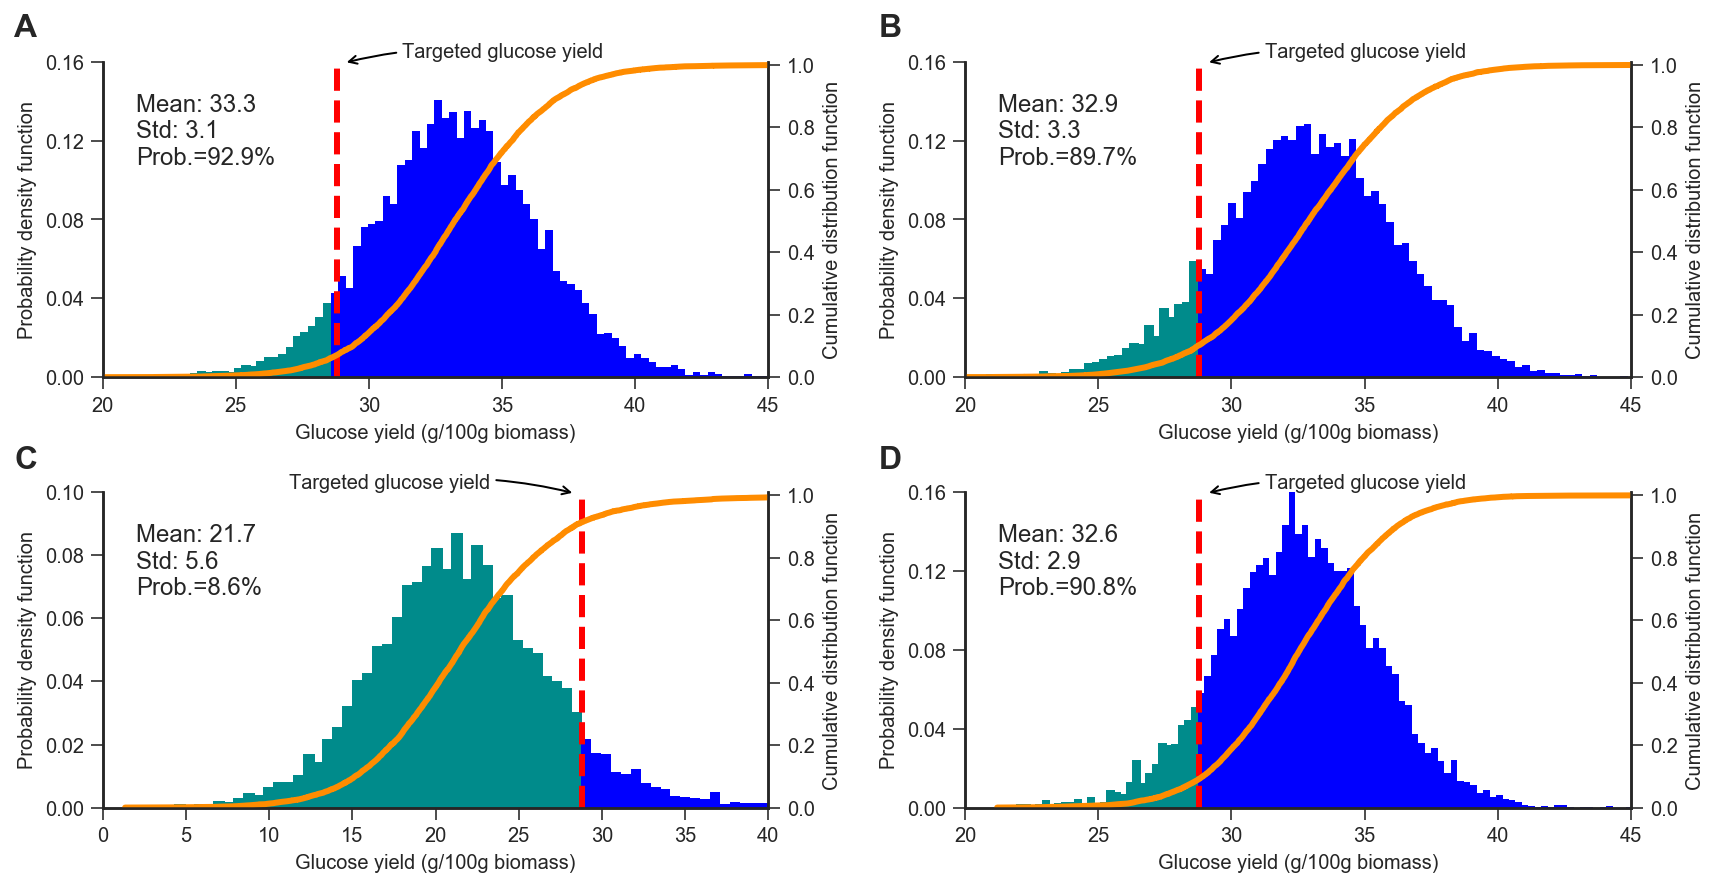

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))
xss = np.linspace(20, 45, 2000)
xss2 = np.linspace(0, 40, 4000)
n1, bins1, patches1 = ax1.hist(cs_tot_glu, bins=100, color='blue', normed=True)
ind1 = np.searchsorted(bins1, thres)
for ind in range(ind1-1):
    patches1[ind].set_color('darkcyan')
ax1.set_xlim([20, 45])
ax1.set_ylim([0, 0.16])
ax1.set_yticks(np.linspace(0, 0.16, 5))
ax1.axvline(thres, color='r', linewidth=3, linestyle='--')
ax1.set_xlabel('Glucose yield (g/100g biomass)')
ax1.set_ylabel('Probability density function')
ax1.text(0.05, 0.9, "Mean: {:.1f}\nStd: {:.1f}\nProb.={:.1%}".format(cs.gluYields_.mean(), cs.gluYields_.std(), 1 - cs_ecdf(thres)),
         fontsize=12, transform=ax1.transAxes, va='top')

ax12 = ax1.twinx()
ax12.plot(cs_ecdf.x, cs_ecdf.y, color='darkorange', linewidth=3)
ax12.set_ylim([0.0, 1.01])
ax12.set_ylabel('Cumulative distribution function')

ax12.annotate("Targeted glucose yield",
                xy=(thres, 1), xycoords='data',
                xytext=(0.45, 1.0), textcoords='axes fraction',
#                 xytext=(30, 1.0), textcoords='data',
                arrowprops=dict(
                                fc="k", ec="k",
                                arrowstyle="->", #linestyle="dashed",
                                shrinkA=1, shrinkB=5,
                                connectionstyle='arc3,rad=0.1',
                                ),
              horizontalalignment='top', verticalalignment='left',
            )
ax1.spines['top'].set_color('none')
ax12.spines['top'].set_color('none')

n2, bins2, patches2 = ax2.hist(swg_tot_glu, bins=100, color='blue',normed=True)
ind2 = np.searchsorted(bins2, thres)
for ind in range(ind2-1):
    patches2[ind].set_color('darkcyan')
ax2.set_xlim([20, 45])
ax2.set_ylim([0, 0.16])
ax2.set_yticks(np.linspace(0, 0.16, 5))
ax2.axvline(thres, color='r', linewidth=3, linestyle='--')
ax2.set_xlabel('Glucose yield (g/100g biomass)')
ax2.set_ylabel('Probability density function')
ax2.text(0.05, 0.9, "Mean: {:.1f}\nStd: {:.1f}\nProb.={:.1%}".format(swg.gluYields_.mean(), swg.gluYields_.std(), 1 - swg_ecdf(thres)),
         fontsize=12, transform=ax2.transAxes, va='top')
ax22 = ax2.twinx()
ax22.plot(swg_ecdf.x, swg_ecdf.y, color='darkorange', linewidth=3)
ax22.set_ylim([0.0, 1.01])
ax22.set_ylabel('Cumulative distribution function')

ax22.annotate("Targeted glucose yield",
                xy=(thres, 1), xycoords='data',
                xytext=(0.45, 1.0), textcoords='axes fraction',
#                 xytext=(30, 1.0), textcoords='data',
                arrowprops=dict(
                                fc="k", ec="k",
                                arrowstyle="->", #linestyle="dashed",
                                shrinkA=1, shrinkB=5,
                                connectionstyle='arc3,rad=0.1',
                                ),
              horizontalalignment='top', verticalalignment='left',
            )
ax2.spines['top'].set_color('none')
ax22.spines['top'].set_color('none')

n3, bins3, patches3 = ax3.hist(grass_tot_glu, bins=200, color='blue',normed=True)
ind3 = np.searchsorted(bins3, thres)
for ind in range(ind3-1):
    patches3[ind].set_color('darkcyan')
ax3.set_xlim([0, 40])
ax3.set_ylim(0, 0.1)
ax3.axvline(thres, color='r', linewidth=3, linestyle='--')
ax3.set_xlabel('Glucose yield (g/100g biomass)')
ax3.set_ylabel('Probability density function')
ax3.text(0.05, 0.9, "Mean: {:.1f}\nStd: {:.1f}\nProb.={:.1%}".format(grass.gluYields_.mean(), grass.gluYields_.std(), 1 - grass_ecdf(thres)),
         fontsize=12, transform=ax3.transAxes, va='top')
ax32 = ax3.twinx()
ax32.plot(grass_ecdf.x, grass_ecdf.y, color='darkorange', linewidth=3)
ax32.set_ylim([0.0, 1.01])
ax32.set_ylabel('Cumulative distribution function')

ax32.annotate("Targeted glucose yield",
                xy=(thres, 1), xycoords='data',
                xytext=(0.28, 1.0), textcoords='axes fraction',
#                 xytext=(30, 1.0), textcoords='data',
                arrowprops=dict(
                                fc="k", ec="k",
                                arrowstyle="->", #linestyle="dashed",
                                shrinkA=1, shrinkB=5,
                                connectionstyle='arc3,rad=-0.1',
                                ),
              horizontalalignment='top', verticalalignment='right',
            )
ax3.spines['top'].set_color('none')
ax32.spines['top'].set_color('none')

n4, bins4, patches4 = ax4.hist(mix_tot_glu, bins=100, color='blue',normed=True)
ind4 = np.searchsorted(bins4, thres)
for ind in range(ind4-1):
    patches4[ind].set_color('darkcyan')
ax4.set_xlim([20, 45])
ax4.set_ylim([0, 0.16])
ax4.set_yticks(np.linspace(0, 0.16, 5))
ax4.axvline(thres, color='r', linewidth=3, linestyle='--')
ax4.set_xlabel('Glucose yield (g/100g biomass)')
ax4.set_ylabel('Probability density function')
ax4.text(0.05, 0.9, "Mean: {:.1f}\nStd: {:.1f}\nProb.={:.1%}".format(mix.gluYields_.mean(), mix.gluYields_.std(), 1 - mix_ecdf(thres)),
         fontsize=12, transform=ax4.transAxes, va='top')
ax42 = ax4.twinx()
ax42.plot(mix_ecdf.x, mix_ecdf.y, color='darkorange', linewidth=3)
ax42.set_ylim([0.0, 1.01])
ax42.set_ylabel('Cumulative distribution function')

ax42.annotate("Targeted glucose yield",
                xy=(thres, 1), xycoords='data',
                xytext=(0.45, 1.0), textcoords='axes fraction',
#                 xytext=(30, 1.0), textcoords='data',
                arrowprops=dict(
                                fc="k", ec="k",
                                arrowstyle="->", #linestyle="dashed",
                                shrinkA=1, shrinkB=5,
                                connectionstyle='arc3,rad=0.1',
                                ),
              horizontalalignment='top', verticalalignment='left',
            )
ax4.spines['top'].set_color('none')
ax42.spines['top'].set_color('none')
# sns.despine()
fig.tight_layout(w_pad=2.0, h_pad=2.0)
fig.text(0.01, 0.99, 'A', fontsize=16, fontweight='bold')
fig.text(0.51, 0.99, 'B', fontsize=16, fontweight='bold')
fig.text(0.01, 0.49, 'C', fontsize=16, fontweight='bold')
fig.text(0.51, 0.49, 'D', fontsize=16, fontweight='bold')
fig.savefig('PDF.png', dpi=300, bbox_inches='tight')

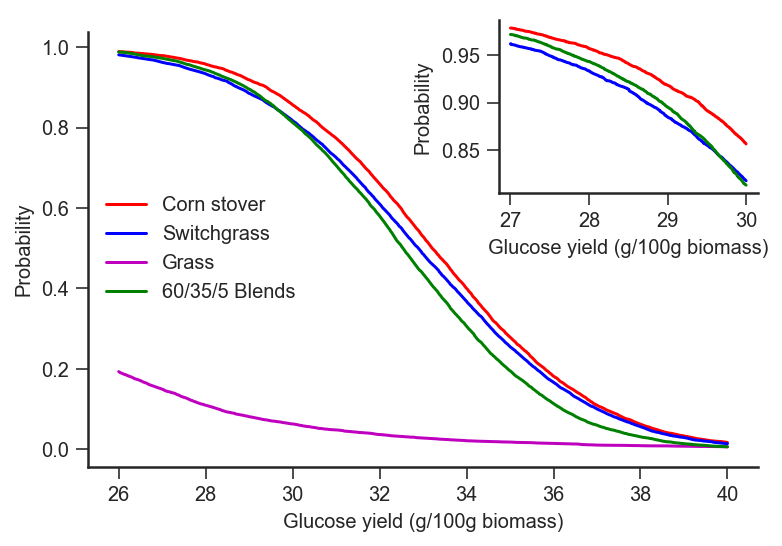

In [27]:
fig, ax = plt.subplots()
x = np.linspace(26, 40, 500)
csy = 1 - cs_ecdf(x)
swgy = 1 - swg_ecdf(x)
grassy = 1 - grass_ecdf(x)
mixy = 1 - mix_ecdf(x)
ax.plot(x, csy, c='r', label='Corn stover')
ax.plot(x, swgy, c='b', label='Switchgrass')
ax.plot(x, grassy, c='m', label='Grass')
ax.plot(x, mixy, c='g', label='60/35/5 Blends')
ax.legend(loc=6)
ax.set_xlabel('Glucose yield (g/100g biomass)')
ax.set_ylabel('Probability')
ax2 = fig.add_axes([0.6, 0.6, 0.3, 0.3])
x2 = np.linspace(27, 30, 1000)
csy2 = 1 - cs_ecdf(x2)
swgy2 = 1 - swg_ecdf(x2)
grassy2 = 1 - grass_ecdf(x2)
mixy2 = 1 - mix_ecdf(x2)
ax2.plot(x2, csy2, c='r', label='Corn stover')
ax2.plot(x2, swgy2, c='b', label='Switchgrass')
ax2.plot(x2, mixy2, c='g', label='60/35/5 Blends')
ax2.set_xlabel('Glucose yield (g/100g biomass)')
ax2.set_ylabel('Probability')
sns.despine()
fig.savefig('probability.png', dpi=300)

### Only consider input uncertainty

In [28]:
glucan_trace[1]

{'Intercept': 12.514148133496487,
 'glucan': 0.43145141168848838,
 'lignin': -0.064833146611442766,
 'sd': 3.6710525621210071,
 'sd_log__': 1.3004784226145918,
 'xylan': 0.31606633252283761}

In [29]:
glucan, xylan, lignin, intercept = \
glucan_trace['glucan'].mean(), glucan_trace['xylan'].mean(), \
glucan_trace['lignin'].mean(), glucan_trace['Intercept'].mean()

In [30]:
glucan, xylan, lignin, intercept

(0.40828574623202663,
 0.49462436769200246,
 -0.15374576682976221,
 11.425314864925511)

In [31]:
class biomass2():
    '''
    This class only considers variable uncertainty, model uncertainty is not included.
    '''
    def __init__(self, price, xylan_trace=xylan_trace, glucan_trace=glucan_trace):
        self.glucan = None
        self.xylan = None
        self.lignin =None
        self.ext = None
        self.price = price
        self.xylan_trace = xylan_trace
        self.glucan_trace = glucan_trace
        
    def lin_reg(self, trace):
        '''
        This function generates linear function based on linear regression resuls.
        '''
        c1, c2, c3, intercept = trace['glucan'].mean(), trace['xylan'].mean(), trace['lignin'].mean(), trace['Intercept'].mean()
        return lambda x1, x2, x3: c1 * x1 + c2 * x2 + c3 * x3 + intercept
        
    def calYields(self):
        if (self.glucan is None) or (self.xylan is None) or (self.lignin is None) or (self.ext is None):
            raise RuntimeError('Please define feedstock component first !')
        else:
            tot_xyl = self.lin_reg(self.xylan_trace)     # The function to predict total xylan yields
            self.xylYields_ = tot_xyl(self.glucan, self.xylan, self.lignin)

            tot_glu = self.lin_reg(self.glucan_trace)    # The function to predict total glucan yields
            self.gluYields_ = tot_glu(self.glucan, self.xylan, self.lignin)
            
            return self.xylYields_, self.gluYields_
    
    def meetTarget(self, target=thres):
        '''
        Returns the probability of meeting yield target
        '''
        tot_xyl, tot_glu = self.calYields()
        glu_ecdf = ECDF(tot_glu)
        xyl_ecdf = ECDF(tot_xyl)
        inv_cdfg = interp1d(glu_ecdf.y, glu_ecdf.x, bounds_error=False, assume_sorted=True)
        inv_cdfx = interp1d(xyl_ecdf.y, xyl_ecdf.x, bounds_error=False, assume_sorted=True)
        return 1 - glu_ecdf(target)

In [32]:
cs2 = biomass2(csPrice)
cs2.glucan = cs_glucan
cs2.xylan = cs_xylan
cs2.lignin = cs_lignin
cs2.ext = cs_ext

cs2_tot_xyl, cs2_tot_glu = cs2.calYields()

In [33]:
swg2 = biomass2(swgPrice)
swg2.glucan = swg_glucan
swg2.xylan = swg_xylan
swg2.lignin = swg_lignin
swg2.ext = swg_ext

swg2_tot_xyl, swg2_tot_glu = swg2.calYields()

In [34]:
grass2 = biomass2(grassPrice)
grass2.glucan = grass_glucan
grass2.xylan = grass_xylan
grass2.lignin = grass_lignin
grass2.ext = grass_ext

grass2_tot_xyl, grass2_tot_glu = grass2.calYields()

In [35]:
def blend2(csRatio=0.6, swgRatio=0.35, grassRatio=0.05):
    '''
    This function returns the blended biomass feedstock given the blending ratios of cs, swg and grass.
    '''
#     if round(csRatio + swgRatio + grassRatio, 10) != round(1.0, 10):
#         raise RuntimeError('Blending ratios must add up to 1! It is now {} !'.format(csRatio + swgRatio + grassRatio))
    if False:
        pass
    else:
        blendsPrice = csRatio * cs.price + swgRatio * + swg.price + grassRatio * grass.price
        blends = biomass2(blendsPrice)
        blends.glucan = csRatio * cs.glucan + swgRatio * swg.glucan + grassRatio * grass.glucan
        blends.xylan = csRatio * cs.xylan + swgRatio * + swg.xylan + grassRatio * grass.xylan
        blends.lignin = csRatio * cs.lignin + swgRatio * + swg.lignin + grassRatio * grass.lignin
        blends.ext = csRatio * cs.ext + swgRatio * + swg.ext + grassRatio * grass.ext
        return blends

In [36]:
mix2 = blend2()
mix2_tot_xyl, mix2_tot_glu = mix2.calYields()

In [37]:
cs_iu = cs2.gluYields_.std()
cs_tu = cs.gluYields_.std()
swg_iu = swg2.gluYields_.std()
swg_tu = swg.gluYields_.std()
grass_iu = grass2.gluYields_.std()
grass_tu = grass.gluYields_.std()
mix_iu = mix2.gluYields_.std()
mix_tu = mix.gluYields_.std()

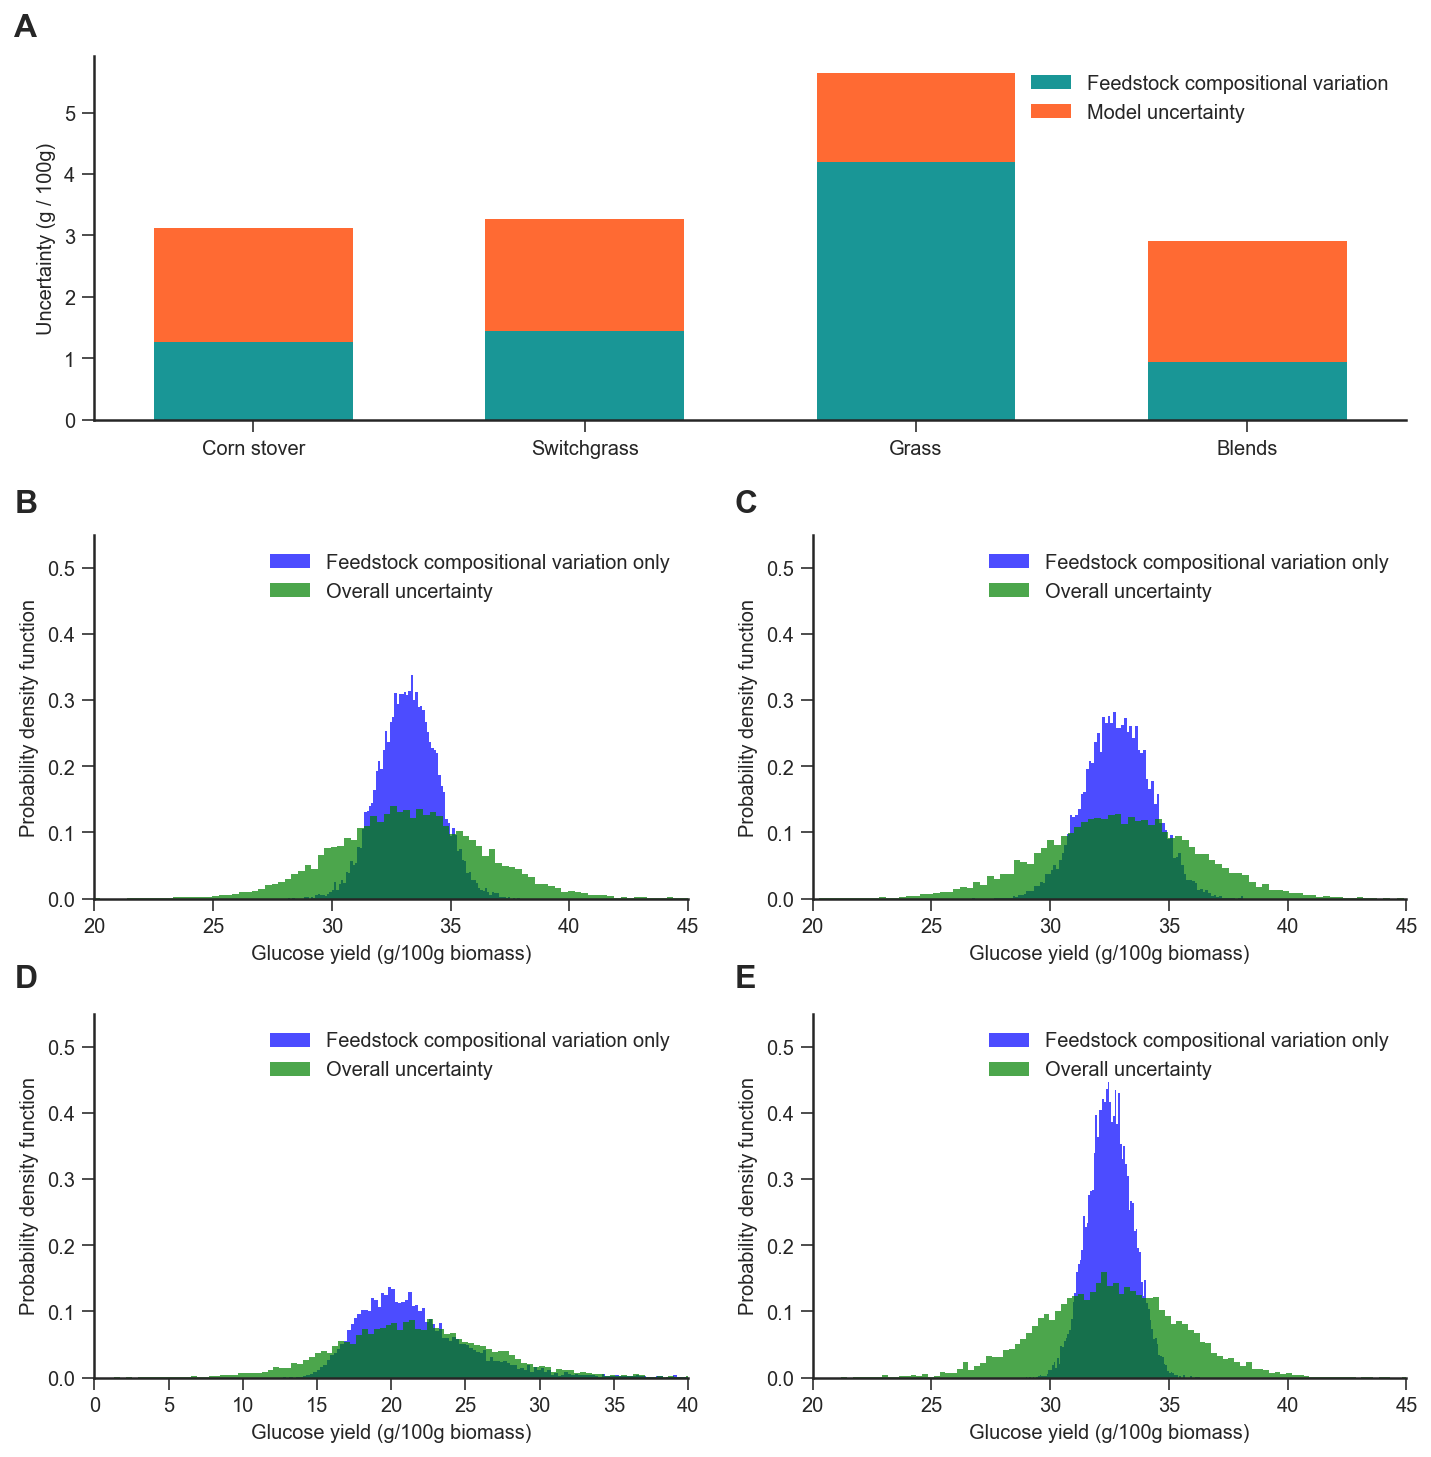

In [38]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 2)
ax1 = fig.add_subplot(gs[:-2, :])
ax2 = fig.add_subplot(gs[-2, 0])
ax3 = fig.add_subplot(gs[-2, 1])
ax4 = fig.add_subplot(gs[-1, 0])
ax5 = fig.add_subplot(gs[-1, 1])

ax1.bar([0,1,2,3], [cs_iu, swg_iu, grass_iu, mix_iu], label='Feedstock compositional variation', fc='darkcyan', alpha=.9, width=0.6)
ax1.bar([0,1,2,3], [cs_tu-cs_iu, swg_tu-swg_iu, grass_tu-grass_iu, mix_tu-mix_iu], bottom=[cs_iu, swg_iu, grass_iu, mix_iu], 
        label='Model uncertainty', fc='orangered', width=0.6, alpha=0.8)
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(['Corn stover', 'Switchgrass', 'Grass', 'Blends'])
ax1.legend()
ax1.set_ylabel('Uncertainty (g / 100g)')

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))
xss = np.linspace(20, 45, 2000)
xss2 = np.linspace(0, 40, 4000)
ax2.hist(cs2_tot_glu, bins=100, color='blue', normed=True, alpha=0.7, label='Feedstock compositional variation only')
ax2.hist(cs_tot_glu, bins=100, color='green', normed=True, stacked=True, alpha=0.7, label='Overall uncertainty')
ax2.set_xlim([20, 45])
ax2.set_ylim([0, 0.55])
# ax2.set_yticks(np.linspace(0, 0.6, 7))
ax2.set_xlabel('Glucose yield (g/100g biomass)')
ax2.set_ylabel('Probability density function')
ax2.legend()

ax3.hist(swg2_tot_glu, bins=100, color='blue', normed=True, alpha=0.7, label='Feedstock compositional variation only')
ax3.hist(swg_tot_glu, bins=100, color='green', normed=True, stacked=True, alpha=0.7, label='Overall uncertainty')
ax3.set_xlim([20, 45])
ax3.set_ylim([0, 0.55])
# ax3.set_yticks(np.linspace(0, 0.6, 7))
ax3.set_xlabel('Glucose yield (g/100g biomass)')
ax3.set_ylabel('Probability density function')
ax3.legend()

ax4.hist(grass2_tot_glu, bins=300, color='blue', normed=True, alpha=0.7, label='Feedstock compositional variation only')
ax4.hist(grass_tot_glu, bins=300, color='green', normed=True, stacked=True, alpha=0.7, label='Overall uncertainty')
ax4.set_xlim([0, 40])
ax4.set_ylim([0, 0.55])
# ax4.set_yticks(np.linspace(0, 0.6, 7))
ax4.set_xlabel('Glucose yield (g/100g biomass)')
ax4.set_ylabel('Probability density function')
ax4.legend()

ax5.hist(mix2_tot_glu, bins=100, color='blue', normed=True, alpha=0.7, label='Feedstock compositional variation only')
ax5.hist(mix_tot_glu, bins=100, color='green', normed=True, stacked=True, alpha=0.7, label='Overall uncertainty')
ax5.set_xlim([20, 45])
ax5.set_ylim([0, 0.55])
# ax5.set_yticks(np.linspace(0, 0.6, 7))
ax5.set_xlabel('Glucose yield (g/100g biomass)')
ax5.set_ylabel('Probability density function')
ax5.legend()

sns.despine()

fig.tight_layout(w_pad=2.0, h_pad=2.0)
fig.text(0.01, 0.99, 'A', fontsize=16, fontweight='bold')
fig.text(0.01, 0.66, 'B', fontsize=16, fontweight='bold')
fig.text(0.51, 0.66, 'C', fontsize=16, fontweight='bold')
fig.text(0.01, 0.33, 'D', fontsize=16, fontweight='bold')
fig.text(0.51, 0.33, 'E', fontsize=16, fontweight='bold')
fig.savefig('PDF2.png', dpi=300, bbox_inches='tight')

##### What is the probability of yield higher than target with varying blending ratios ?

In [39]:
# Calculate price as a function of availability for feedstocks
def price_calc(x1, y1, x2, y2):
    '''
    Calculate the function of price vs. availability given
    two points (x1, y1) and (x2, y2)
    '''
    k = (y2 - y1) / (x2 - x1)   # (220, 78) and (880, 84) on the line
    b = y1 - k * x1
    return lambda avail: k * avail + b

# (200, 79) and (880, 84) on the line of corn stover
csp = price_calc(200, 79, 880, 84)
# (200, 78.75) and (880, 85.5) on the line of switchgrass
swgp = price_calc(200, 78.75, 880, 85.5)
# (200, 75) and (880, 78) on the line of grass, based on estimation
grassp = price_calc(200, 61, 880, 64)

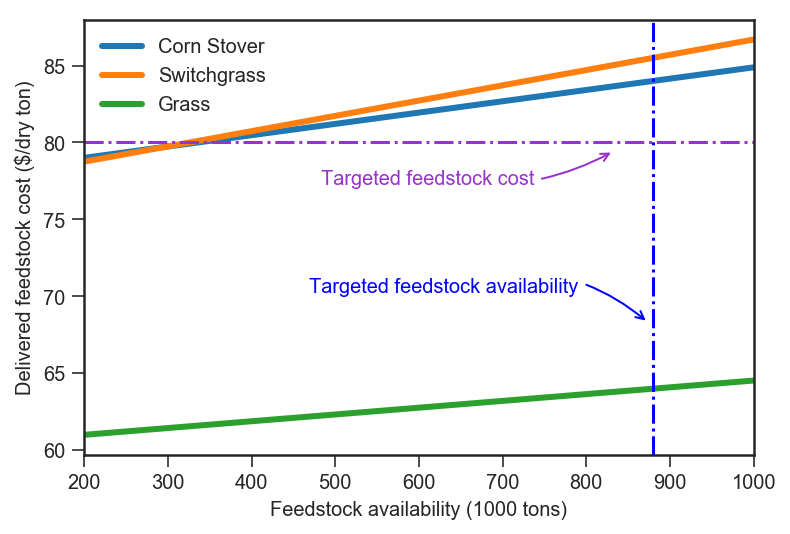

In [40]:
xp = np.linspace(200, 1000, 1000)
csyp = csp(xp)
swgyp = swgp(xp)
grassyp = grassp(xp)

plt.plot(xp, csyp, label='Corn Stover', lw=3)
plt.plot(xp, swgyp, label='Switchgrass', lw=3)
plt.plot(xp, grassyp, label='Grass', lw=3)
plt.gca().axhline(80, color='darkorchid', ls='-.')
plt.gca().axvline(880, color='b', ls='-.')
plt.xlim([200, 1000])
plt.legend()
plt.xlabel('Feedstock availability (1000 tons)')
plt.ylabel('Delivered feedstock cost ($/dry ton)')
plt.annotate("Targeted feedstock availability", xy=(880, 68), xycoords='data', xytext=(630, 70), textcoords='data',
            arrowprops=dict(fc='b', ec='b', arrowstyle='->', shrinkA=2, shrinkB=5, connectionstyle='arc3, rad=-0.3'),
            ha='center', va='bottom', 
            color='b', size='medium')
plt.annotate("Targeted feedstock cost", xy=(850, 80), xycoords='data', xytext=(610, 77), textcoords='data',
             arrowprops=dict(fc='darkorchid', ec='darkorchid', arrowstyle='->', shrinkA=2, shrinkB=10, connectionstyle='arc3, rad=0.2'),
             ha='center', va='bottom',
             color='darkorchid')
# sns.despine()
plt.savefig('feedstock_cost.jpg', dpi=300)
plt.show()

In [41]:
def mix_price(csb, swgb):
    csb *= 880
    swgb *= 880
    grassb = 880 - csb - swgb
    price = csp(csb) * csb + swgp(swgb) * swgb + grassp(grassb) * grassb
    price /= 880
    return price

In [42]:
l = [[], [], []]
i=0
for p in [70, 75, 80]:
    for swgb in np.arange(0, 1.01, 0.005):
        f = lambda csb, p: mix_price(csb, swgb) - p
        for csb in np.arange(0, 1.01, 0.005):
            if np.abs(f(csb, p))<0.01:
                l[i].append((csb, swgb, 1-csb-swgb))
                continue
    i+=1

In [43]:
space = {}
space['x1'] = hp.uniform('x1', 0, 1)
space['x2'] = hp.uniform('x2', 0, 1)

In [44]:
def yields_obj(params, cons=80):
    x1 = params['x1']
    x2 = params['x2']
    csRatio = x1
    swgRatio = (1 - x1) * x2
    grassRatio = 1 - csRatio - swgRatio
    if mix_price(csRatio, swgRatio) > cons:
        return 0
    else:
        mix = blend(csRatio, swgRatio, grassRatio)
        mix.calYields()
        return -mix.gluYields_.mean()

In [45]:
def prob_obj(params, cons=80):
    x1 = params['x1']
    x2 = params['x2']
    csRatio = x1
    swgRatio = (1 - x1) * x2
    grassRatio = 1 - csRatio - swgRatio
    
    if mix_price(csRatio, swgRatio) > cons:
        return 1
    else:
        mix = blend(csRatio, swgRatio, grassRatio)
        mix.calYields()
        mix_ecdf = ECDF(mix.gluYields_)
        inv_cdfm = interp1d(mix_ecdf.y, mix_ecdf.x, bounds_error=False, assume_sorted=True)

        return mix_ecdf(thres)

In [46]:
def invest_obj(params, cons=80):
    x1 = params['x1']
    x2 = params['x2']
    csRatio = x1
    swgRatio = (1 - x1) * x2
    grassRatio = 1 - csRatio - swgRatio
    
    if (mix_price(csRatio, swgRatio) > cons) or (prob(csRatio, swgRatio, grassRatio) < 0.9):
        return 0
    else:
        yields = y(csRatio, swgRatio, grassRatio)
        cost = mix_price(csRatio, swgRatio)
        return -yields/cost

In [47]:
def y(cs, swg, grass):
    total = cs + swg + grass
    csRatio = cs / total
    swgRatio = swg / total
    grassRatio = 1 - csRatio - swgRatio
    mix_price(cs, swgb)
    mix = blend(csRatio, swgRatio, grassRatio)
    mix.calYields()
    return mix.gluYields_.mean()

def prob(cs, swg, grass):
    total = cs + swg + grass
    csRatio = cs / total
    swgRatio = swg / total
    grassRatio = 1 - csRatio - swgRatio
    mix = blend(csRatio, swgRatio, grassRatio)
    mix.calYields()
    mix_ecdf = ECDF(mix.gluYields_)
    inv_cdfm = interp1d(mix_ecdf.y, mix_ecdf.x, bounds_error=False, assume_sorted=True)

    return 1-mix_ecdf(thres)

In [48]:
r = np.random.RandomState(1)
trials1 = Trials()
yields_best = fmin(yields_obj, space, algo=tpe.suggest, max_evals=500, trials=trials1, rstate=r)
trials2 = Trials()
prob_best = fmin(prob_obj, space, algo=tpe.suggest, max_evals=500, trials=trials2, rstate=r)
trials3 = Trials()
invest_best = fmin(invest_obj, space, algo=tpe.suggest, max_evals=500, trials=trials3, rstate=r)

In [49]:
yields_opt = space_eval(space, yields_best)
yields_opt

{'x1': 0.5424171542103917, 'x2': 0.9159289400227848}

In [50]:
yields_x1, yields_x2 = yields_opt['x1'], yields_opt['x2']
cs_ratio1 = yields_x1
swg_ratio1 = (1 - yields_x1) * yields_x2
grass_ratio1 = 1 - cs_ratio1 - swg_ratio1

cs_ratio1, swg_ratio1, grass_ratio1

(0.5424171542103917, 0.4191133709166853, 0.03846947487292296)

In [51]:
prob_opt = space_eval(space, prob_best)
prob_opt

{'x1': 0.5460012354788549, 'x2': 0.9159245265464246}

In [52]:
prob_x1, prob_x2 = prob_opt['x1'], prob_opt['x2']
cs_ratio2 = prob_x1
swg_ratio2 = (1 - prob_x1) * prob_x2
grass_ratio2 = 1 - cs_ratio2 - swg_ratio2

cs_ratio2, swg_ratio2, grass_ratio2

(0.5460012354788549, 0.41582860344669154, 0.038170161074453535)

In [53]:
invest_opt = space_eval(space, invest_best)
invest_opt

{'x1': 0.5620199590230351, 'x2': 0.9064103125093453}

In [54]:
invest_x1, invest_x2 = invest_opt['x1'], invest_opt['x2']
cs_ratio3 = invest_x1
swg_ratio3 = (1 - invest_x1) * invest_x2
grass_ratio3 = 1 - cs_ratio3 - swg_ratio3

cs_ratio3, swg_ratio3, grass_ratio3

(0.5620199590230351, 0.3969896258147866, 0.04099041516217827)

In [55]:
def invest_obj(params, cons=80):
    x1 = params['x1']
    x2 = params['x2']
    csRatio = x1
    swgRatio = (1 - x1) * x2
    grassRatio = 1 - csRatio - swgRatio
    
    if (mix_price(csRatio, swgRatio) > cons):
        return 0
    else:
        yields = y(csRatio, swgRatio, grassRatio)
        cost = mix_price(csRatio, swgRatio)
        return -yields/cost

def yields_pesudo(cons):
    return lambda x: yields_obj(x, cons=cons)

def prob_pesudo(cons):
    return lambda x: prob_obj(x, cons=cons)

def invest_pesudo(cons):
    return lambda x: invest_obj(x, cons=cons)

In [56]:
costs = np.arange(70, 86, 1)
yields_res = []
prob_res = []
invest_res = []

for cost in costs:
    trials1 = Trials()
    yields_best0 = fmin(yields_pesudo(cost), space, algo=tpe.suggest, max_evals=500, trials=trials1, rstate=r)
    trials2 = Trials()
    prob_best0 = fmin(prob_pesudo(cost), space, algo=tpe.suggest, max_evals=500, trials=trials2, rstate=r)
    trials3 = Trials()
    invest_best0 = fmin(invest_pesudo(cost), space, algo=tpe.suggest, max_evals=500, trials=trials3, rstate=r)
    
    yields_opt0 = space_eval(space, yields_best0)
    prob_opt0 = space_eval(space, prob_best0)
    invest_opt0 = space_eval(space, invest_best0)
    
    yields_res.append(-yields_pesudo(cost)(yields_opt0))
    prob_res.append(1-prob_pesudo(cost)(prob_opt0))
    invest_res.append(-invest_pesudo(cost)(invest_opt0))

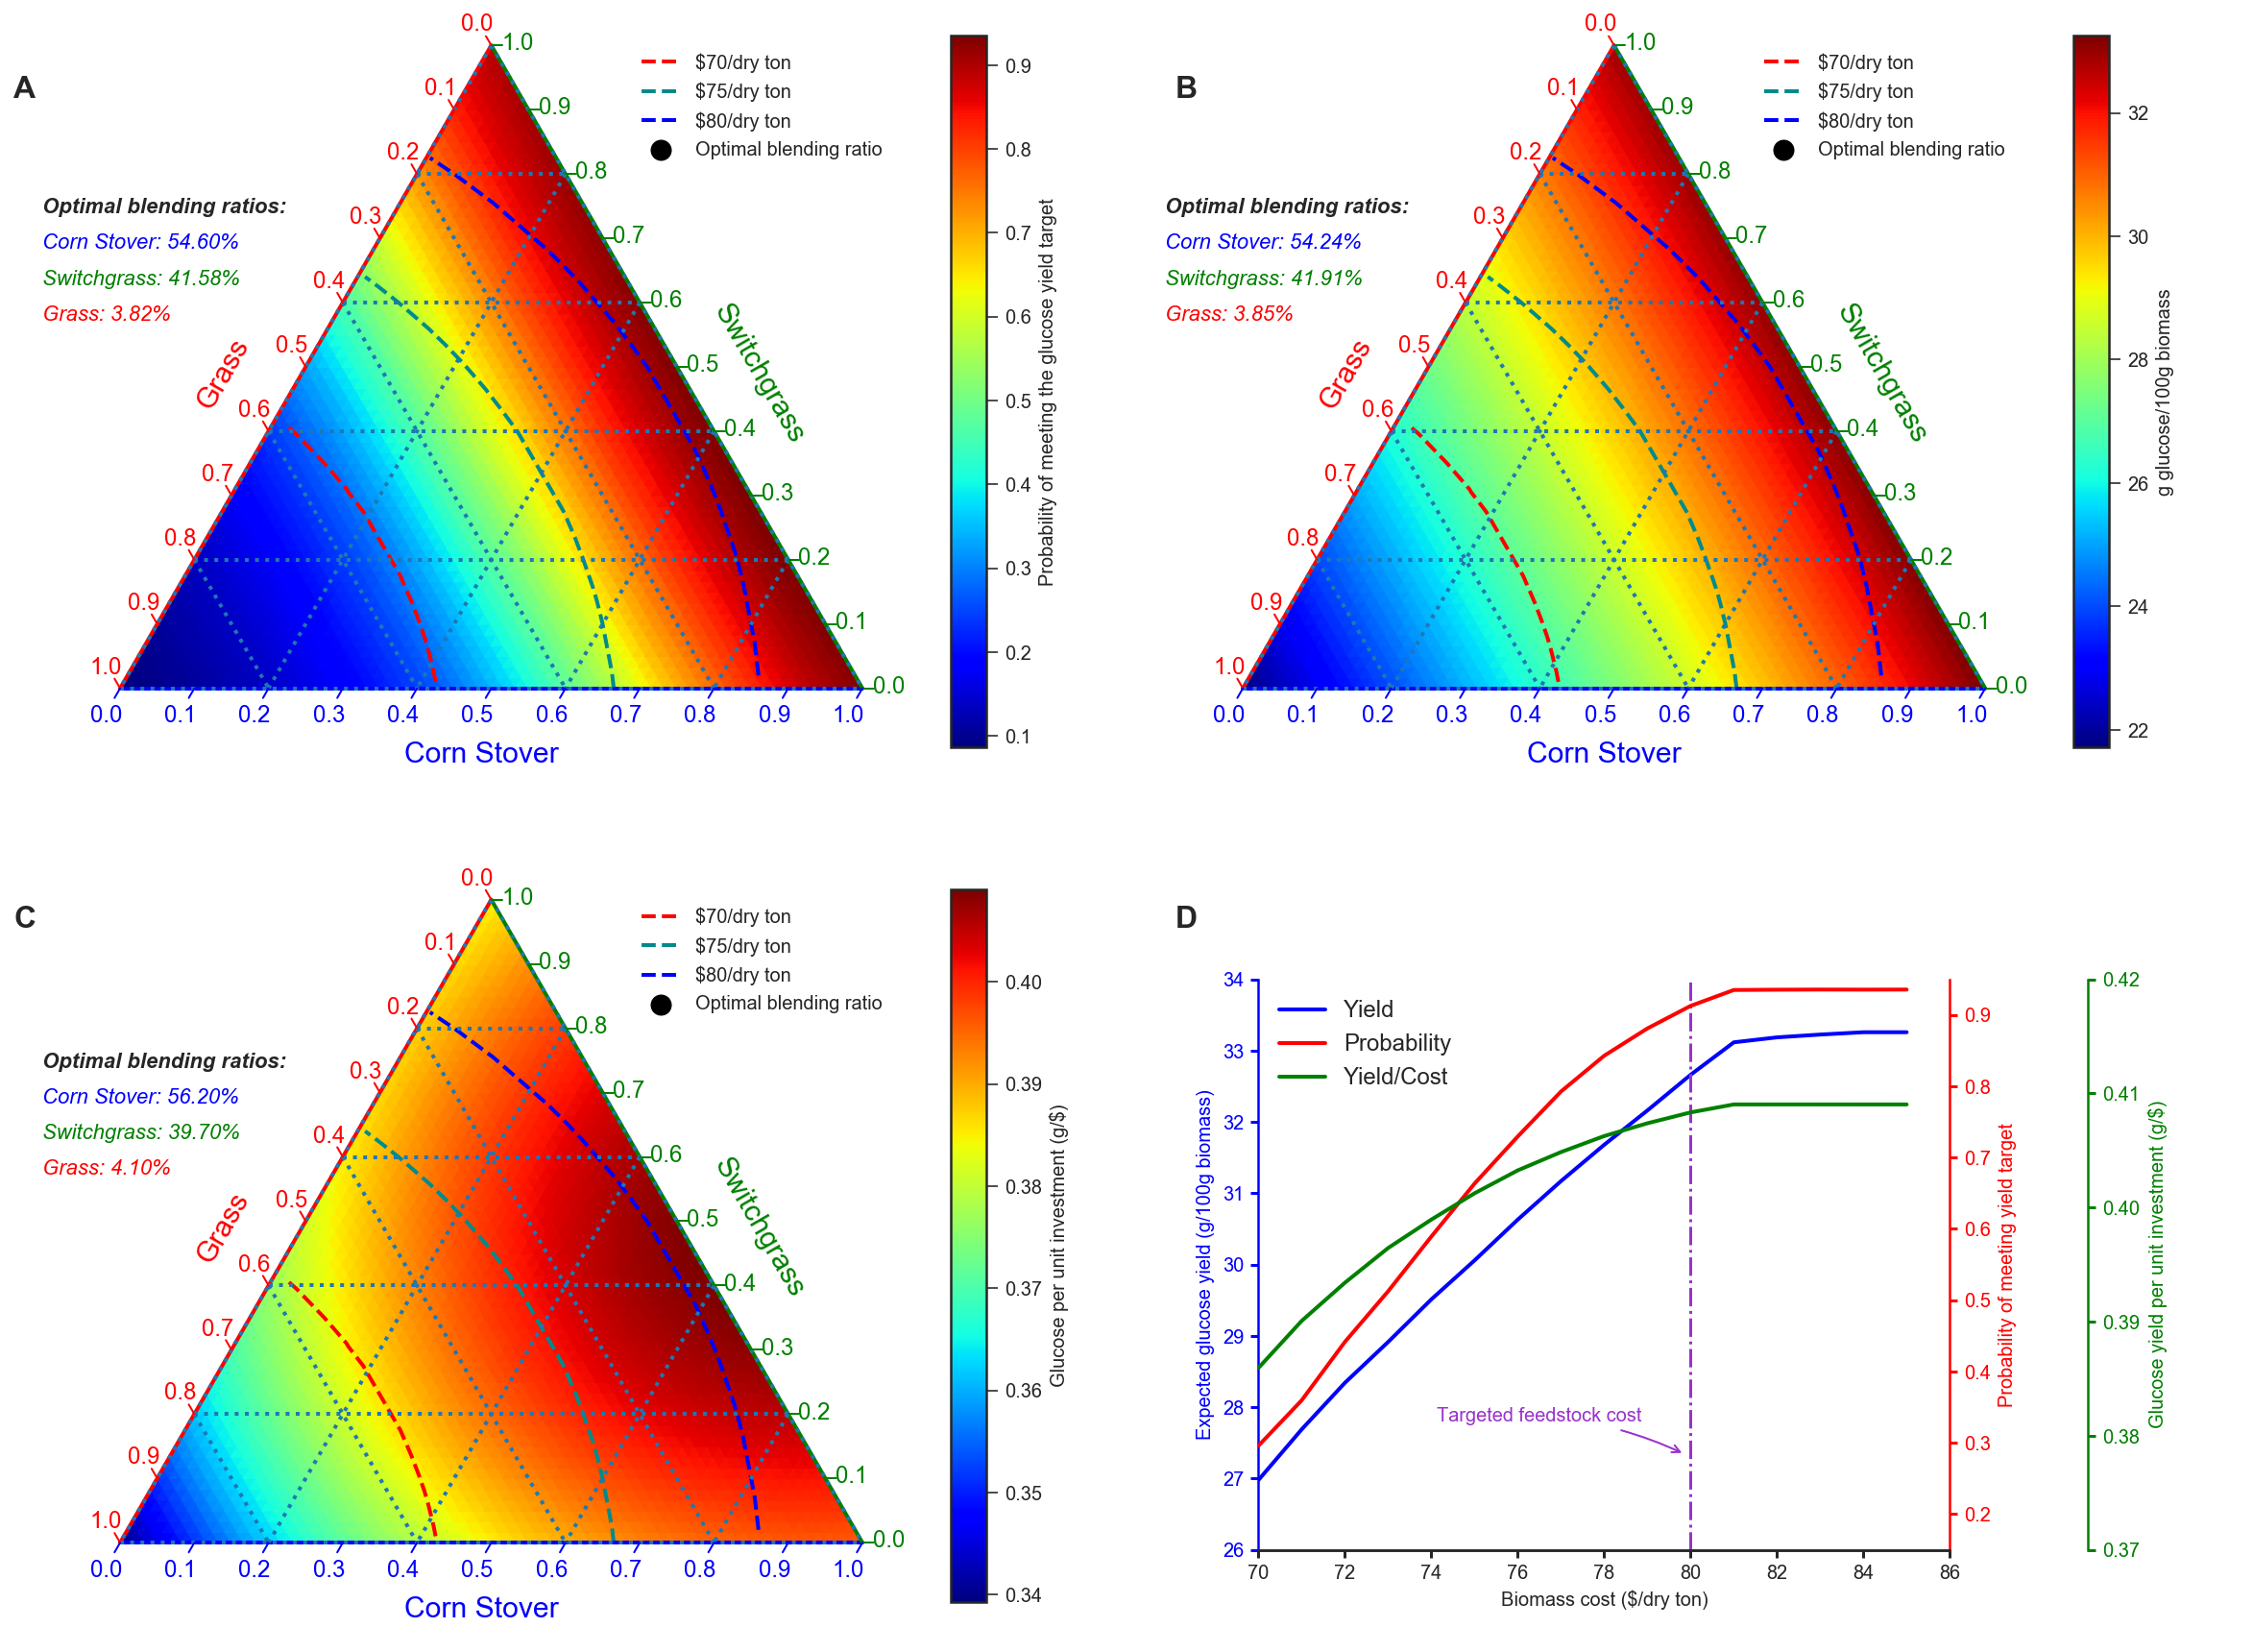

In [57]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
# Probability

def gen_prob(scale=60):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = prob(i, j, k)
    return d

scale=60
figure, tax = ternary.figure(ax=ax1, scale=scale)
tax.ax.axis('equal')
tax.ax.axis('off')
data = gen_prob(scale=scale)
tax.plot(np.array(l[0])*scale, linewidth=2, color='red', linestyle='--', label='$70/dry ton')
tax.plot(np.array(l[1])*scale, linewidth=2, color='darkcyan', linestyle='--', label='$75/dry ton')
tax.plot(np.array(l[2])*scale, linewidth=2, color='b', linestyle='--', label='$80/dry ton')

tax.plot(np.array([[ 0.596, 0.359, 0.045], [0.596, 0.359, 0.045]])*scale, linewidth=20, color='k', linestyle='--')

tax.heatmap(data, style="triangular", cmap=plt.get_cmap('jet'), cbarlabel='Probability of meeting the glucose yield target')

optimal_point = [(cs_ratio2 * scale, swg_ratio2 * scale, grass_ratio2 * scale)]
tax.scatter(optimal_point, marker='o', color='k', s=100, label="Optimal blending ratio")

axes_colors={'l': 'r', 'b': 'b', 'r': 'g'}
tax.boundary(linewidth=2.0, axes_colors=axes_colors)
tax.left_axis_label("Grass", fontsize=15, offset=0.12, color='r')
tax.right_axis_label("Switchgrass", fontsize=15, offset=0.12, color='g')
tax.bottom_axis_label("Corn Stover", fontsize=15, offset=0.05, color='b')
ticks = [round(i / float(scale), 10) for i in range(0, scale+1, int(scale/10))]
tax.gridlines(multiple=scale/5, linewidth=2)
tax.ticks(ticks=ticks, linewidth=1, alpha=1, tick_formats='%.1f', offset=0.015, fontsize=12, axes_colors=axes_colors)
tax.clear_matplotlib_ticks()
tax.legend()
ax1.text(-0.05, 0.75, 'Optimal blending ratios:', fontweight='bold', fontstyle='italic', fontsize=11, transform=ax1.transAxes)
ax1.text(-0.05, 0.7, 'Corn Stover: {:.2%}'.format(cs_ratio2), fontstyle='italic', fontsize=11,
        transform=ax1.transAxes, color='b')
ax1.text(-0.05, 0.65, 'Switchgrass: {:.2%}'.format(swg_ratio2), fontstyle='italic', fontsize=11, 
        transform=ax1.transAxes, color='g')
ax1.text(-0.05, 0.6, 'Grass: {:.2%}'.format(grass_ratio2), fontstyle='italic', fontsize=11, 
        transform=ax1.transAxes, color='r')

# Yield
def gen_y(scale=60):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = y(i, j, k)
    return d

scale=60
# fig, ax = plt.subplots(figsize=(15,15))
figure, tax = ternary.figure(ax=ax2, scale=scale)
figure.set_size_inches(20, 15)
tax.ax.axis('equal')
tax.ax.axis('off')
data = gen_y(scale=scale)
# p1 = (0.69*scale, 0*scale, 0.31*scale)
# p2 = (0*scale, 0.7*scale, 0.3*scale)

optimal_point = [(cs_ratio1 * scale, swg_ratio1 * scale, grass_ratio1 * scale)]
tax.scatter(optimal_point, marker='o', color='k', s=100, label="Optimal blending ratio")

tax.plot(np.array(l[0])*scale, linewidth=2, color='red', linestyle='--', label='$70/dry ton')
tax.plot(np.array(l[1])*scale, linewidth=2, color='darkcyan', linestyle='--', label='$75/dry ton')
tax.plot(np.array(l[2])*scale, linewidth=2, color='b', linestyle='--', label='$80/dry ton')

tax.heatmap(data, style="triangular", cmap=plt.get_cmap('jet'), cbarlabel='g glucose/100g biomass')
axes_colors={'l': 'r', 'b': 'b', 'r': 'g'}
tax.boundary(linewidth=2.0, axes_colors=axes_colors)
tax.left_axis_label("Grass", fontsize=15, offset=0.12, color='r')
tax.right_axis_label("Switchgrass", fontsize=15, offset=0.12, color='g')
tax.bottom_axis_label("Corn Stover", fontsize=15, offset=0.05, color='b')
ticks = [round(i / float(scale), 10) for i in range(0, scale+1, int(scale/10))]
tax.gridlines(multiple=scale/5, linewidth=2)
tax.ticks(ticks=ticks, linewidth=1, alpha=1, tick_formats='%.1f', offset=0.015, fontsize=12, axes_colors=axes_colors)
tax.clear_matplotlib_ticks()
tax.legend()
ax2.text(-0.05, 0.75, 'Optimal blending ratios:', fontweight='bold', fontstyle='italic', fontsize=11, transform=ax2.transAxes)
ax2.text(-0.05, 0.7, 'Corn Stover: {:.2%}'.format(cs_ratio1), fontstyle='italic', fontsize=11,
        transform=ax2.transAxes, color='b')
ax2.text(-0.05, 0.65, 'Switchgrass: {:.2%}'.format(swg_ratio1), fontstyle='italic', fontsize=11, 
        transform=ax2.transAxes, color='g')
ax2.text(-0.05, 0.6, 'Grass: {:.2%}'.format(grass_ratio1), fontstyle='italic', fontsize=11, 
        transform=ax2.transAxes, color='r')

# Yield/Cost
def invest(cs, swg, grass):
    total = cs + swg + grass
    csRatio = cs / total
    swgRatio = swg / total
    grassRatio = 1 - csRatio - swgRatio
    yields = y(csRatio, swgRatio, grassRatio)
    cost = mix_price(csRatio, swgRatio)
    return yields/cost
    
def gen_invest(scale=60):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = invest(i, j, k)
    return d

scale=60
# fig, ax = plt.subplots(figsize=(15,15))
figure, tax = ternary.figure(ax=ax3, scale=scale)
# figure.set_size_inches(10, 7.5)
tax.ax.axis('equal')
tax.ax.axis('off')
data = gen_invest(scale=scale)

optimal_point = [(cs_ratio3 * scale, swg_ratio3 * scale, grass_ratio3 * scale)]
tax.scatter(optimal_point, marker='o', color='k', s=100, label="Optimal blending ratio")

tax.plot(np.array(l[0])*scale, linewidth=2, color='red', linestyle='--', label='$70/dry ton')
tax.plot(np.array(l[1])*scale, linewidth=2, color='darkcyan', linestyle='--', label='$75/dry ton')
tax.plot(np.array(l[2])*scale, linewidth=2, color='b', linestyle='--', label='$80/dry ton')

tax.heatmap(data, style="triangular", cmap=plt.get_cmap('jet'), cbarlabel='Glucose per unit investment (g/$)')
axes_colors={'l': 'r', 'b': 'b', 'r': 'g'}
tax.boundary(linewidth=2.0, axes_colors=axes_colors)
# tax.set_title("Average Glucaose Yield (g/100 g)", fontsize=16)
tax.left_axis_label("Grass", fontsize=15, offset=0.12, color='r')
tax.right_axis_label("Switchgrass", fontsize=15, offset=0.12, color='g')
tax.bottom_axis_label("Corn Stover", fontsize=15, offset=0.05, color='b')
ticks = [round(i / float(scale), 10) for i in range(0, scale+1, int(scale/10))]
tax.gridlines(multiple=scale/5, linewidth=2)
tax.ticks(ticks=ticks, linewidth=1, alpha=1, tick_formats='%.1f', offset=0.015, fontsize=12, axes_colors=axes_colors)
tax.clear_matplotlib_ticks()
tax.legend()
ax3.text(-0.05, 0.75, 'Optimal blending ratios:', fontweight='bold', fontstyle='italic', fontsize=11, transform=ax3.transAxes)
ax3.text(-0.05, 0.7, 'Corn Stover: {:.2%}'.format(cs_ratio3), fontstyle='italic', fontsize=11,
        transform=ax3.transAxes, color='b')
ax3.text(-0.05, 0.65, 'Switchgrass: {:.2%}'.format(swg_ratio3), fontstyle='italic', fontsize=11, 
        transform=ax3.transAxes, color='g')
ax3.text(-0.05, 0.6, 'Grass: {:.2%}'.format(grass_ratio3), fontstyle='italic', fontsize=11, 
        transform=ax3.transAxes, color='r')
# fig.text(0.2, 0.8, 'C', fontweight='bold', fontsize=16)
# tax.savefig('yield_optimal', dpi=300)

ax4.axis('off')

fig.subplots_adjust(wspace=0.1)

host = fig.add_axes([0.55, 0.15, 0.25, 0.275])
par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.2))
par1.spines['top'].set_color(None)
par2.spines['top'].set_color(None)
par2.spines['bottom'].set_color(None)
par2.spines['left'].set_color(None)
host.spines['top'].set_color(None)

p1, = host.plot(costs, yields_res, 'b-', label='Yield', lw=2)
p2, = par1.plot(costs, prob_res, 'r-', label='Probability', lw=2)
p3, = par2.plot(costs, invest_res, 'g-', label='Yield/Cost', lw=2)
par1.spines['right'].set_color(p2.get_color())
par2.spines['right'].set_color(p3.get_color())
host.spines['left'].set_color(p1.get_color())
par1.spines['left'].set_visible(False)
host.spines['right'].set_visible(False)

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
host.set_xlabel('Biomass cost ($/dry ton)')
host.set_ylabel('Expected glucose yield (g/100g biomass)', color=p1.get_color())
par1.set_ylabel('Probability of meeting yield target', color=p2.get_color())
par2.set_ylabel('Glucose yield per unit investment (g/$)', color=p3.get_color())

host.set_xlim(70, 86)
host.set_ylim(26, 34)
par1.set_ylim(0.15, 0.95)
par2.set_ylim(0.37, 0.42)
host.axvline(80, color='darkorchid', ls='-.')
host.annotate('Targeted feedstock cost', xy=(80, 27.3), xycoords='data', xytext=(76.5, 28), textcoords='data',
              arrowprops=dict(fc='darkorchid', ec='darkorchid', arrowstyle='->', shrinkA=2, shrinkB=5, connectionstyle='arc3, rad=-0.1'),
              ha='center', va='top', 
              color='darkorchid', size='medium')

lines=[p1, p2, p3]
host.legend(lines, [l.get_label() for l in lines], loc='upper left', fontsize=12)
fig.text(0.1, 0.85, 'A', fontweight='bold', fontsize=16)
fig.text(0.52, 0.85, 'B', fontweight='bold', fontsize=16)
fig.text(0.1, 0.45, 'C', fontweight='bold', fontsize=16)
fig.text(0.52, 0.45, 'D', fontweight='bold', fontsize=16)
# fig.tight_layout()
fig.savefig('combined.png', dpi=300, bbox_inches='tight')